In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, classification_report, confusion_matrix, roc_auc_score
import lightgbm as lgb
import xgboost as xgb

# Load datasets
train_df = pd.read_csv('cleaned_train.csv')
test_df = pd.read_csv('cleaned_test.csv')
holdout_df = pd.read_csv('cleaned_holdout.csv')

# Create a new target variable for the first model
train_df['STATUS_BINARY'] = train_df['STATUS'].apply(lambda x: 1 if x != 0 else 0)
test_df['STATUS_BINARY'] = test_df['STATUS'].apply(lambda x: 1 if x != 0 else 0)
holdout_df['STATUS_BINARY'] = holdout_df['STATUS'].apply(lambda x: 1 if x != 0 else 0)

In [2]:

# Create new features
current_year = 2024
for df in [train_df, test_df, holdout_df]:
    df['PREMIUM_CHANGE'] = df['RENEWAL_PREMIUM_CHANGE_TWO_TERM'].abs()
    df['DRVR_AGE_DIFF'] = df['POL_MAX_DRVR_AGE'] - df['POL_MIN_DRVR_AGE']
    df['BILL_PREM_DIFF'] = df['POL_ANNL_TTL_BILL_PREM_AMT'] - df['AVG_TERM_PREM']
    df['AVG_COMP_BI_RTNG_SYM'] = (df['MAX_COMP_RTNG_SYM_CD'] + df['MAX_BI_RTNG_SYM_CD']) / 2
    df['VEHICLE_AGE'] = current_year - df['NEW_VEH_MODEL_YR']

# Define the combined feature set with domain-specific features and the new features
combined_features = [
    'GARAGE_LOC_ZIP_CD', 'STATE_ABBR', 'AVG_VEHICLE_MILEAGE', 
    'ADV_QTE_DAY_CNT', 'YEARS_WITH_HIG',
    'PREMIUM_CHANGE', 'VEHICLE_AGE',
    'DRVR_AGE_DIFF', 'BILL_PREM_DIFF', 'AVG_COMP_BI_RTNG_SYM'
]


# Prepare the datasets
X_train_combined = train_df[combined_features]
y_train = train_df['STATUS_BINARY']
X_test_combined = test_df[combined_features]
y_test = test_df['STATUS_BINARY']
X_holdout = holdout_df[combined_features]
y_holdout = holdout_df['STATUS_BINARY']

# Fit RandomForest, LightGBM, and XGBoost models on the combined features
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}


for name, model in models.items():
    model.fit(X_train_combined, y_train)
    y_holdout_pred = model.predict(X_holdout)
    print(f"{name} Classification Report on Holdout Set:")
    print(classification_report(y_holdout, y_holdout_pred))
    print(confusion_matrix(y_holdout, y_holdout_pred))

# Evaluate class-wise performance for each model
precision_results = {}

for name, model in models.items():
    y_holdout_pred = model.predict(X_holdout)
    precision_results[name] = precision_score(y_holdout, y_holdout_pred, average=None)

precision_df = pd.DataFrame(precision_results, index=['Class 0', 'Class 1'])

# Plot the precision for each class
precision_df.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Class-Wise Precision for Different Models on Holdout Set', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Random Forest Cross-Validation Accuracy: 0.8341 ± 0.0002
Random Forest Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     31771
           1       0.76      0.05      0.10      4921

    accuracy                           0.87     36692
   macro avg       0.82      0.52      0.51     36692
weighted avg       0.86      0.87      0.82     36692

[[31692    79]
 [ 4668   253]]


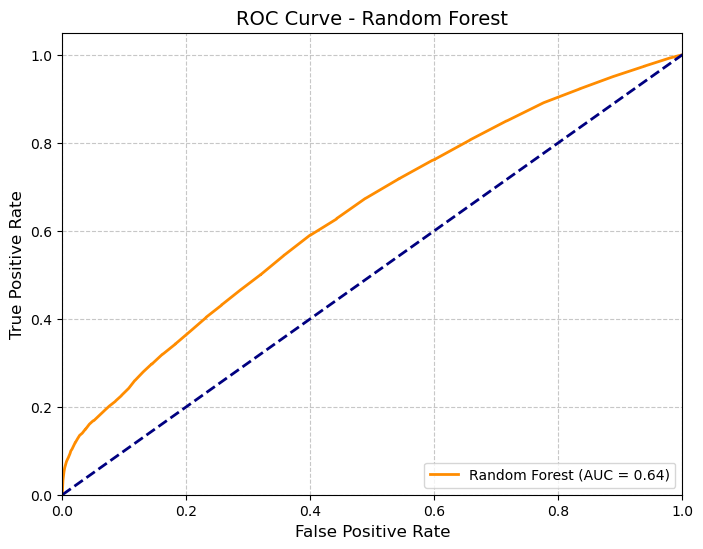

[LightGBM] [Info] Number of positive: 32671, number of negative: 179298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1488
[LightGBM] [Info] Number of data points in the train set: 211969, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154131 -> initscore=-1.702561
[LightGBM] [Info] Start training from score -1.702561
[LightGBM] [Info] Number of positive: 32671, number of negative: 179298
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1489
[LightGBM] [Info] Number of data points in the train set: 211969, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154131 -> initscore=-1.70256

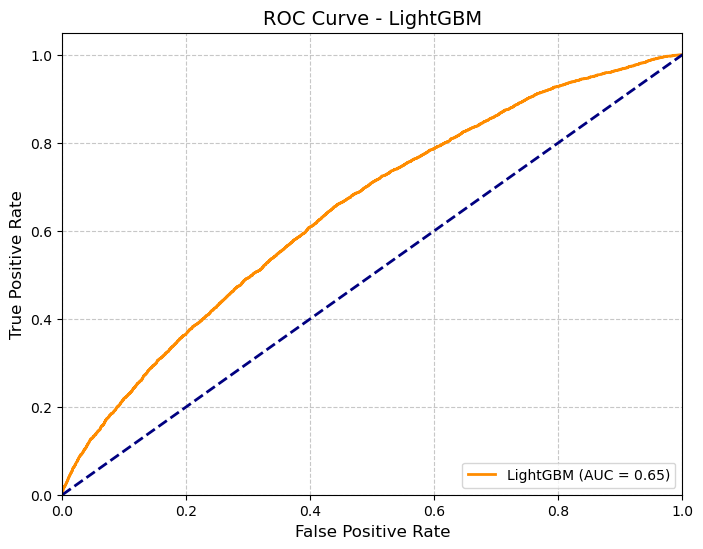

C:\Users\peter\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\peter\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\peter\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\peter\anaconda3\Lib\site-packages\

XGBoost Cross-Validation Accuracy: 0.8461 ± 0.0003


C:\Users\peter\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     31771
           1       0.58      0.01      0.02      4921

    accuracy                           0.87     36692
   macro avg       0.72      0.51      0.48     36692
weighted avg       0.83      0.87      0.81     36692

[[31727    44]
 [ 4860    61]]


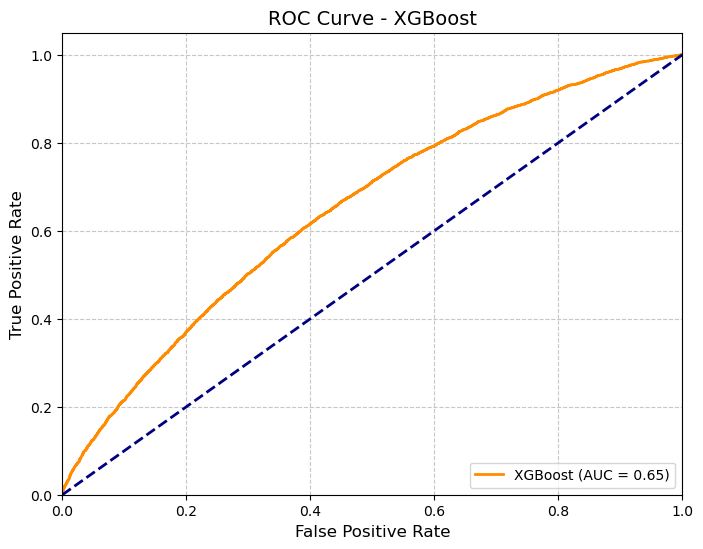

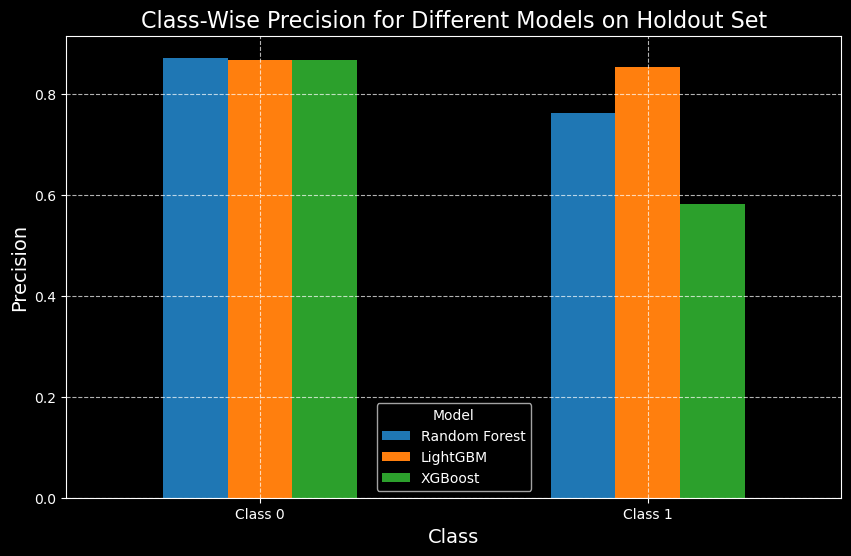

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, roc_curve, auc
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the datasets
X_train_combined = train_df[combined_features]
y_train = train_df['STATUS_BINARY']
X_test_combined = test_df[combined_features]
y_test = test_df['STATUS_BINARY']
X_holdout = holdout_df[combined_features]
y_holdout = holdout_df['STATUS_BINARY']

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

# Define stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize dictionaries to store results
roc_auc_scores = {}
fpr = {}
tpr = {}

# Fit models and evaluate on holdout set
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_combined, y_train, cv=skf, scoring='accuracy')
    print(f"{name} Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    
    # Fit the model
    model.fit(X_train_combined, y_train)
    y_holdout_pred = model.predict(X_holdout)
    
    # Print classification report and confusion matrix
    print(f"{name} Classification Report on Holdout Set:")
    print(classification_report(y_holdout, y_holdout_pred))
    print(confusion_matrix(y_holdout, y_holdout_pred))
    
    # Calculate ROC curve and AUC
    y_scores = model.predict_proba(X_holdout)[:, 1]  # Probability of class 1
    fpr[name], tpr[name], _ = roc_curve(y_holdout, y_scores)
    roc_auc_scores[name] = auc(fpr[name], tpr[name])

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr[name], tpr[name], color='darkorange', lw=2, label=f'{name} (AUC = {roc_auc_scores[name]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {name}', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Evaluate class-wise performance for each model
precision_results = {}

for name, model in models.items():
    y_holdout_pred = model.predict(X_holdout)
    precision_results[name] = precision_score(y_holdout, y_holdout_pred, average=None)

precision_df = pd.DataFrame(precision_results, index=['Class 0', 'Class 1'])

# Plot the precision for each class with a dark color palette
plt.style.use('dark_background')
precision_df.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Class-Wise Precision for Different Models on Holdout Set', fontsize=16, color='white')
plt.xlabel('Class', fontsize=14, color='white')
plt.ylabel('Precision', fontsize=14, color='white')
plt.xticks(rotation=0, color='white')
plt.yticks(color='white')
plt.legend(title='Model')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


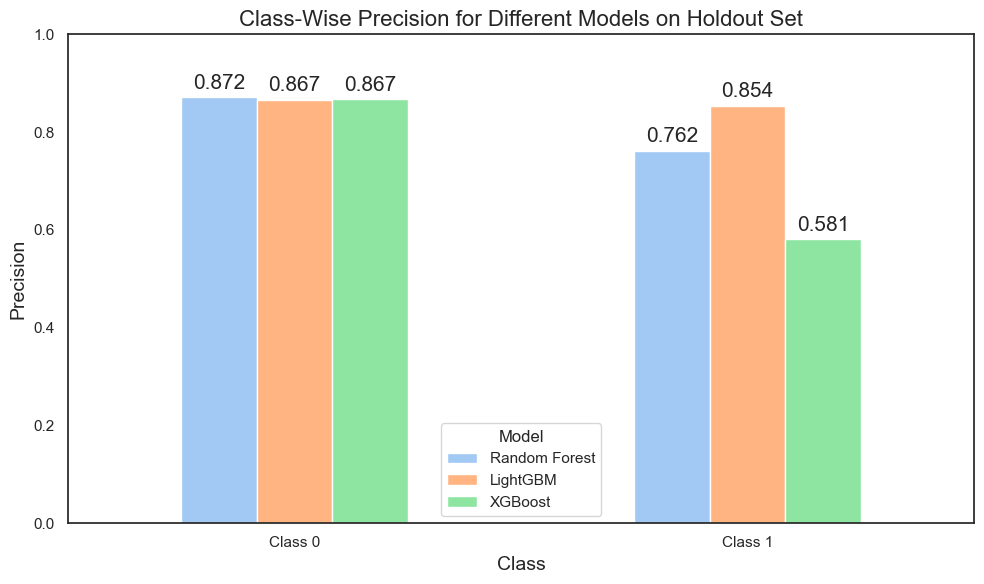

In [6]:
# Evaluate class-wise performance for each model
precision_results = {}

for name, model in models.items():
    y_holdout_pred = model.predict(X_holdout)
    precision_results[name] = precision_score(y_holdout, y_holdout_pred, average=None)

precision_df = pd.DataFrame(precision_results, index=['Class 0', 'Class 1'])

# Set the plot style to white background without grid
sns.set(style="white")

# Plot the precision for each class
colors = sns.color_palette('pastel', n_colors=len(models))
ax = precision_df.plot(kind='bar', figsize=(10, 6), color=colors)
plt.title('Class-Wise Precision for Different Models on Holdout Set', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Model', loc='lower center', ncol=1 )

# Add precision numbers on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=15)

plt.ylim(0, 1)  # Ensure y-axis starts from 0 to 1
plt.tight_layout()
plt.show()


   Random Forest  LightGBM   XGBoost
0       0.310000  0.320170  0.317209
1       0.270000  0.336706  0.354182
2       0.176667  0.053210  0.055671
3       0.070000  0.178272  0.177497
4       0.180000  0.170890  0.098632


C:\Users\peter\AppData\Local\Temp\ipykernel_22220\952930283.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probabilities_df[name], label=name, shade=True)
C:\Users\peter\AppData\Local\Temp\ipykernel_22220\952930283.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probabilities_df[name], label=name, shade=True)
C:\Users\peter\AppData\Local\Temp\ipykernel_22220\952930283.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(probabilities_df[name], label=name, shade=True)


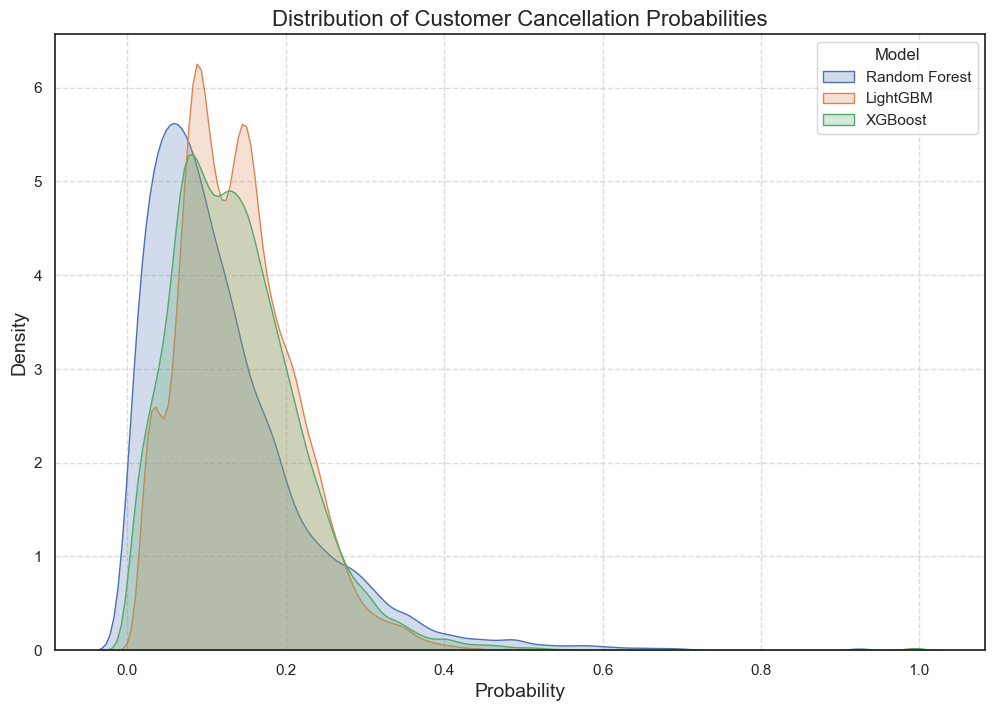

In [7]:
# Get probabilities of customer cancellation (class 1) for each model
probabilities = {}

for name, model in models.items():
    probabilities[name] = model.predict_proba(X_holdout)[:, 1]

# Convert probabilities to DataFrame for easier handling
probabilities_df = pd.DataFrame(probabilities)

# Display the first few rows of probabilities
print(probabilities_df.head())

# Plot the distribution of probabilities for each model
plt.figure(figsize=(12, 8))
for name in probabilities:
    sns.kdeplot(probabilities_df[name], label=name, shade=True)

plt.title('Distribution of Customer Cancellation Probabilities', fontsize=16)
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Model')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Peak Height: Indicates the most probable range of probabilities predicted by each model for customer cancellation.
Spread: Shows the variability or certainty of predictions from each model. A wider spread suggests less certainty in predictions.



A model with a higher and narrower peak around a higher probability range suggests it might be more confident in predicting customer cancellation.


This plot helps you assess how confident each model (Random Forest, LightGBM, XGBoost) is in predicting customer cancellation probabilities and understand the distribution of those predictions. It's useful for comparing the predictive capabilities and confidence levels of different machine learning models in your application.